In [40]:
import pandas as pd
import numpy as np 
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,accuracy_score,f1_score,precision_score,recall_score, confusion_matrix, classification_report

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import precision_score,recall_score,auc

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
train_data = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_labels = pd.read_csv("test_values.csv")

In [43]:
building_damage = train_data.merge(train_labels, how = 'inner', on = 'building_id')

In [44]:
test_labels['damage_grade'] = -1

In [45]:
building_damage = building_damage.append(test_labels, ignore_index=True, sort=False)

In [46]:
building_damage.drop_duplicates(inplace=True)

In [47]:
building_damage = building_damage.drop(columns ="has_secondary_use")

In [48]:
building_damage.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,3.474690e+05,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,...,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000
mean,5.259136e+05,13.897315,701.838052,6258.846760,2.130579,26.538814,8.017014,5.434799,0.088972,0.762077,...,0.033686,0.008136,0.000958,0.000363,0.001053,0.000167,0.000138,0.000078,0.005065,1.428697
std,3.043545e+05,8.032597,412.875674,3646.950564,0.727761,73.527749,4.388646,1.915555,0.284704,0.425813,...,0.180421,0.089832,0.030943,0.019039,0.032438,0.012919,0.011753,0.008815,0.070990,1.498984
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,2.619990e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,5.260710e+05,12.000000,706.000000,6271.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.895880e+05,21.000000,1050.000000,9414.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [49]:
building_damage['damage_grade'].value_counts()

 2    148259
 3     87218
-1     86868
 1     25124
Name: damage_grade, dtype: int64

In [50]:
cat_feats = ['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position','legal_ownership_status',
       'plan_configuration']

In [51]:
train_final = pd.get_dummies(building_damage,columns=cat_feats,drop_first=False)

In [52]:
# Geo_level_1_id

In [53]:
damage1 = {}
damage2 = {}
damage3 = {}
for i,j in (train_final['geo_level_1_id'].value_counts()).iteritems():
    n1 = len(train_final[train_final['damage_grade']==1][train_final['geo_level_1_id']==i])
    n2 = len(train_final[train_final['damage_grade']==2][train_final['geo_level_1_id']==i])
    n3 = len(train_final[train_final['damage_grade']==3][train_final['geo_level_1_id']==i])
    
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
list1 = []
list2 = []
list3 = []
for i in train_final['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))
train_final['prob1_geo1'] = list1
train_final['prob2_geo1'] = list2
train_final['prob3_geo1'] = list3

In [54]:
# Geo_level_2_id

In [55]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in (train_final['geo_level_2_id'].value_counts()).iteritems():
    
    n1 = len(train_final[train_final['damage_grade']==1][train_final['geo_level_2_id']==i])
    n2 = len(train_final[train_final['damage_grade']==2][train_final['geo_level_2_id']==i])
    n3 = len(train_final[train_final['damage_grade']==3][train_final['geo_level_2_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
    
list1 = []
list2 = []
list3 = []

for i in train_final['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

train_final['prob1_geo2'] = list1
train_final['prob2_geo2'] = list2
train_final['prob3_geo2'] = list3

In [56]:
# Geo_level_3_id

In [57]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in (train_final['geo_level_3_id'].value_counts()).iteritems():
    
    n1 = len(train_final[train_final['damage_grade']==1][train_final['geo_level_3_id']==i])
    n2 = len(train_final[train_final['damage_grade']==2][train_final['geo_level_3_id']==i])
    n3 = len(train_final[train_final['damage_grade']==3][train_final['geo_level_3_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
    
list1 = []
list2 = []
list3 = []

for i in train_final['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

train_final['prob1_geo3'] = list1
train_final['prob2_geo3'] = list2
train_final['prob3_geo3'] = list3

In [58]:
train_final.loc[:, ['prob1_geo3', 'prob2_geo3']].tail()

,prob1_geo3,prob2_geo3
347464,0.152174,0.586957
347465,0.000000,0.200000
347466,0.066667,0.666667
347467,0.061224,0.459184
347468,0.457143,0.200000


In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 75 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             260601 non-null  int64  
 1   count_floors_pre_eq                     260601 non-null  int64  
 2   age                                     260601 non-null  int64  
 3   area_percentage                         260601 non-null  int64  
 4   height_percentage                       260601 non-null  int64  
 5   has_superstructure_adobe_mud            260601 non-null  int64  
 6   has_superstructure_mud_mortar_stone     260601 non-null  int64  
 7   has_superstructure_stone_flag           260601 non-null  int64  
 8   has_superstructure_cement_mortar_stone  260601 non-null  int64  
 9   has_superstructure_mud_mortar_brick     260601 non-null  int64  
 10  has_superstructure_cement_mortar_brick  2606

In [60]:
train_final = train_final.drop(columns ="geo_level_1_id")
train_final = train_final.drop(columns ="geo_level_2_id")
train_final = train_final.drop(columns ="geo_level_3_id")

In [61]:
train = train_final[(train_final['damage_grade'] != -1)]
test = train_final[(train_final['damage_grade'] == -1)]
test.index -=260601

In [62]:
train.to_csv('train_final.csv', index=False)
test.to_csv('test_final.csv', index=False)

In [63]:
X = train.drop('damage_grade',axis=1)
y = train['damage_grade']

Always 1

In [34]:
y_pred[y_pred > 0]=1
accuracy = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


TypeError: 'numpy.float64' object is not callable

Always 2

In [32]:
y_pred[y_pred > 0]=2
f1_score = f1_score(y_test, y_pred, average='micro')
print("f1_score:", accuracy)
print(classification_report(y_test, y_pred))

TypeError: 'numpy.float64' object is not callable

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=35)

In [37]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [64]:
model_rf = RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=500)
model_rf.fit(X_train, y_train)
y_pred1 = model_rf.predict(X_test)

print(f'{model_rf} f1 score:')
score = f1_score(y_test, y_pred1, average='micro')
print(f'{score:.4f}')
print('\n')


RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=500) f1 score:
0.7548




Final score  Random forest 0.7363

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7552889411885089
              precision    recall  f1-score   support

           1       0.72      0.49      0.58      3768
           2       0.75      0.87      0.80     22233
           3       0.78      0.64      0.70     13090

    accuracy                           0.76     39091
   macro avg       0.75      0.67      0.70     39091
weighted avg       0.76      0.76      0.75     39091



In [66]:
from sklearn.tree import DecisionTreeClassifier

In [67]:
model_dt = DecisionTreeClassifier(max_depth=8, min_samples_split=2)
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test)

print(f'{model_dt} f1 score:')
score = f1_score(y_test, y_pred, average='micro')
print(f'{score:.4f}')
print('\n')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

DecisionTreeClassifier(max_depth=8) f1 score:
0.7521


Accuracy: 0.7521424368780538
              precision    recall  f1-score   support

           1       0.71      0.48      0.57      3768
           2       0.75      0.87      0.80     22233
           3       0.78      0.64      0.70     13090

    accuracy                           0.75     39091
   macro avg       0.74      0.66      0.69     39091
weighted avg       0.75      0.75      0.75     39091



Final score DT  0.7357

Text(0.5, 0, 'Feature Importance')

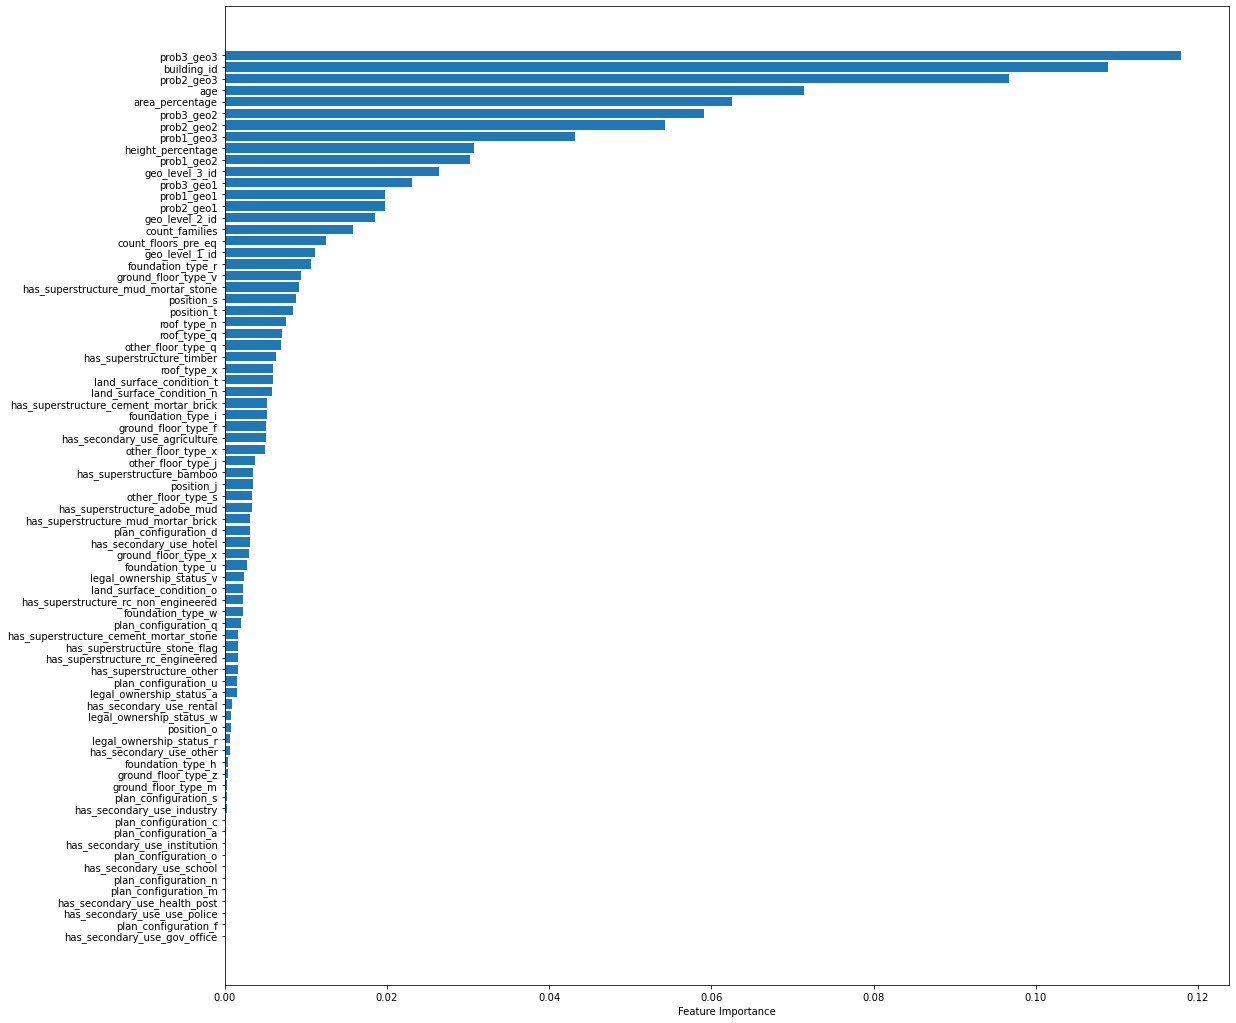

In [27]:
plt.figure(figsize=(18,18))
sort = model_rf.feature_importances_.argsort()
plt.barh(X_train.columns[sort], model_rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

Gradient Boosting prev best .7600

In [79]:
model_gb = GradientBoostingClassifier(learning_rate=0.03,n_estimators=500,max_depth=8,min_samples_split=5)
model_gb.fit(X_train, y_train)
y_pred = model_gb.predict(X_test)

print(f'{model_gb} f1 score:')
score = f1_score(y_test, y_pred, average='micro')
print(f'{score:.4f}')
print('\n')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

GradientBoostingClassifier(learning_rate=0.03, max_depth=8, min_samples_split=5,
                           n_estimators=500) f1 score:
0.7652


Accuracy: 0.7651633368294493
              precision    recall  f1-score   support

           1       0.70      0.60      0.64      3768
           2       0.77      0.85      0.81     22233
           3       0.77      0.67      0.72     13090

    accuracy                           0.77     39091
   macro avg       0.75      0.71      0.72     39091
weighted avg       0.76      0.77      0.76     39091



Final score GB 0.7434

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_xg_boost = le.fit_transform(y_train)

In [48]:
model_xgb = XGBClassifier(booster='gbtree',learning_rate=0.03,n_estimators=500,max_depth=8 )
model_xgb.fit(X_train, y_train_xg_boost)
y_pred = model_xgb.predict(X_test)



In [49]:
yy = y_pred 
yy.tolist()
for i in range(len(yy)):
    yy[i] += 1


In [50]:
print(f'{model_xgb} f1 score:')
score = f1_score(y_test, yy, average='micro')
print(f'{score:.4f}')
print('\n')

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) f1 score:
0.7645




Text(0.5, 0, 'Feature Importance')

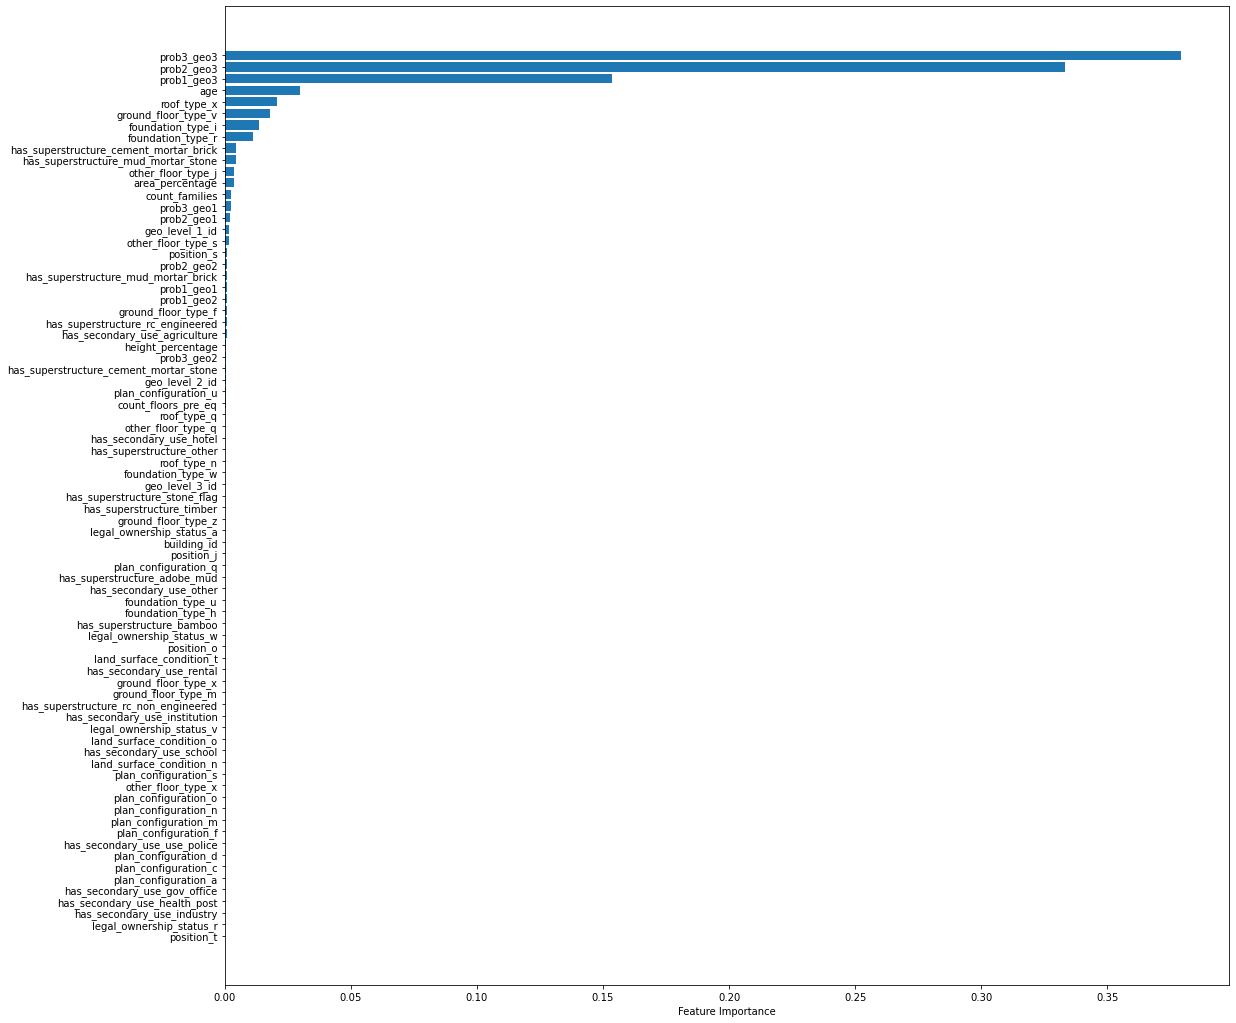

In [33]:
plt.figure(figsize=(18,18))
sort = model_gb.feature_importances_.argsort()
plt.barh(X_train.columns[sort], model_gb.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [78]:
results = list(zip(X, model_gb.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
importance

NameError: name 'model_gb' is not defined

In [73]:
# Predict for test dataset
#test = test.drop('damage_grade',axis=1)
prediction=model_dt.predict(test).tolist()

In [74]:
#for i in range(len(prediction)):
    #prediction[i] += 1
result=pd.DataFrame(prediction)

In [75]:
# Format the prediction as per submission requirement
result['building_id']=test['building_id']
result.rename(columns={0:'damage_grade'},inplace=True)
result=result[['building_id','damage_grade']]
result.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3


In [76]:
result['damage_grade'].value_counts()

2    57708
3    23507
1     5653
Name: damage_grade, dtype: int64

In [88]:
result.to_csv('result.csv',index=False)

In [89]:
result

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [29]:
from sklearn.model_selection import GridSearchCV

In [80]:
parameters = {'n_estimators'         : [ 300, 400,500, 600],
                 'learning_rate' : [0.03, 0.04, 0.06, 0.1, ],
                  'max_depth' : [5,6,7,8,9],
              'min_samples_split': [2, 5, 10],
                 }

In [81]:
Grid_CBC = GridSearchCV(estimator=model_gb, param_grid = parameters, cv = 3, scoring='f1_micro',n_jobs=-1)
Grid_CBC.fit(X_train, y_train)

KeyboardInterrupt: 

In [82]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'